## Part 1: Building and training a mini-inceptionnet

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# install pytorch lighting
! pip install pytorch-lightning --quiet

In [ ]:
# List of imports
from PIL import Image

## PyTorch
import torch
import torch.utils.data as data
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
## PyTorch lightning
import pytorch_lightning as pl
# Torchvision
import torchvision
from torchvision.datasets import SVHN, CIFAR10
from torchvision import transforms

# import TensorBoardLogger
from pytorch_lightning.loggers import TensorBoardLogger

In the following cell we will create an inception block. The class constructor "\_\_init\_\_" will do that job. The roll of each input argument is written inside the docstring. The well-known inception block architecture is provided here also which shows the use of the two dictionaries "c_bottlenet" and "c_out" more clearly.
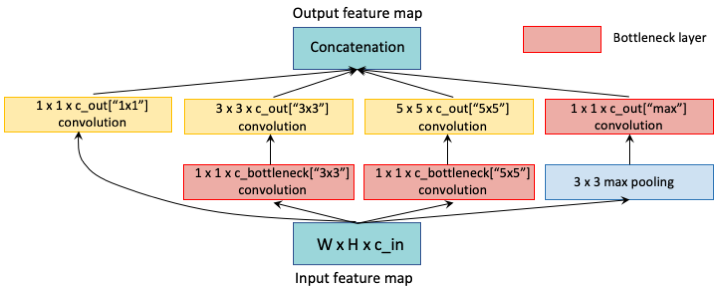

In [ ]:
# Lets first create an inception block
class InceptionBlock(nn.Module):
    def __init__(self, c_in : int, c_bottleneck : dict, c_out : dict, act_fn):
        """
        Input argument:
            c_in - Number of input feature maps from the previous layers
            c_bottleneck - Dictionary with keys "3x3" and "5x5" specifying the number of output channels of the 
                           bottleneck layers [1x1 conv]. These are the number of channels of the feature maps that
                           go into subsequent "3x3" and "5x5" conv operations
            c_out - Dictionary with keys "1x1", "3x3", "5x5", and "max". These are the number of output channels
                    after the corresponding conv operations. Note that these are not the bottleneck operations.
                    Also note that "max" does not mean the max pooling operation as such. It actually denotes the
                    bottleneck operation that comes after the max pool operation. Thus, the 'value' corresponding
                    to the "max" key is the number of output channels after the 1x1 bottleneck operation that comes
                    after the max pool operation
            act_fn - Activation function
        """
        super().__init__()

        
        # 1x1 convolution branch. Note that no bottlenecking is required
        self.conv_1x1 = nn.Sequential(
            nn.Conv2d(c_in, c_out["1x1"], kernel_size=1),
            nn.BatchNorm2d(c_out["1x1"]),
            act_fn()
        )
        
        # 3x3 convolution branch. Note that, here, bottlenecking is required
        self.conv_3x3 = nn.Sequential(
            nn.Conv2d(c_in, c_bottleneck["3x3"], kernel_size=1),
            nn.BatchNorm2d(c_bottleneck["3x3"]),
            act_fn(),
            nn.Conv2d(c_bottleneck["3x3"], c_out["3x3"], kernel_size=3, padding=1),
            nn.BatchNorm2d(c_out["3x3"]),
            act_fn()
        )
        
        # 5x5 convolution branch. Note that, here, bottlenecking is required
        self.conv_5x5 = nn.Sequential(
            nn.Conv2d(c_in, c_bottleneck["5x5"], kernel_size=1),
            nn.BatchNorm2d(c_bottleneck["5x5"]),
            act_fn(),
            nn.Conv2d(c_bottleneck["5x5"], c_out["5x5"], kernel_size=5, padding=2),
            nn.BatchNorm2d(c_out["5x5"]),
            act_fn()
        )
        
        # Max-pool branch. Note that, here, bottlenecking is required
        self.max_pool = nn.Sequential(
            nn.MaxPool2d(kernel_size=3, padding=1, stride=1),
            nn.Conv2d(c_in, c_out["max"], kernel_size=1),
            nn.BatchNorm2d(c_out["max"]),
            act_fn()
        )

    
    def forward(self, x):
      
        x_1x1 = self.conv_1x1(x)
        x_3x3 = self.conv_3x3(x)
        x_5x5 = self.conv_5x5(x)
        x_max = self.max_pool(x)
        x_out = torch.cat([x_1x1, x_3x3, x_5x5, x_max], dim=1)
        return x_out

In [ ]:
class GoogLeNet(pl.LightningModule):
    def __init__(self, InceptionBlock, act_fn, num_classes=10, learning_rate=1e-3):
        '''
        InceptionBlock: The InceptionBlock class defined above
        act_fn: Is a tuple whose first member is "key" and second one is the "value".
        "key" has to be all lowercase and one of the three options - "relu", "tanh", "leakyrelu".
        "value" has to be correspondingly one of the followings - nn.ReLU, nn.Tanh, nn.LeakyRelu.
        This is required for idiosyncracies in Kaiming_normal initialization.
        num_classes: Number of classes in the dataset which equivalently is the number of output nodes
        learning_rate: The learning rate hyperparameter
        '''
        super().__init__()
        # 'save_hyperparameters' saves the values of anything in the __init__ for us to the checkpoint.
        # This is a useful feature.
        self.save_hyperparameters()
        self.InceptionBlock = InceptionBlock
        self.num_classes = num_classes
        self.act_fn = act_fn[1]
        self.act_fn_name = act_fn[0]
        # Calls the network creation method [defined shortly after]
        self._create_network()
        self._init_params()
        self.accuracy = pl.metrics.Accuracy()
    
    def _create_network(self):
        # A first convolution stem network needs to be created which will consist of the following
        # 1. a 3x3 filter with 64 output channels. The output feature map of the stem network will have the same height and width as those of the input
        # 2. Batchnorm
        # 3. activation function [we use self.act_fn defined in the constructor]

        self.stem_net = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            self.act_fn()
        )

        # Stacking inception blocks
        self.inception_blocks = nn.Sequential(
            # First stack of two inception blocks
            self.InceptionBlock(64, c_bottleneck={"3x3":16,"5x5":16}, c_out={"1x1":16,"3x3":32,"5x5":8,"max":8}, act_fn=self.act_fn), # 64 --> 64
            self.InceptionBlock(64, c_bottleneck={"3x3":16,"5x5":16}, c_out={"1x1":24,"3x3":56,"5x5":8,"max":8}, act_fn=self.act_fn), # 64 --> 96
            nn.MaxPool2d(3, stride=2, padding=1), # 32x32 --> 16x16
            # Second stack of two inception blocks
            self.InceptionBlock(96, c_bottleneck={"3x3":32,"5x5":16}, c_out={"1x1":24,"3x3":56,"5x5":8,"max":8}, act_fn=self.act_fn), # 96 --> 96
            self.InceptionBlock(96, c_bottleneck={"3x3":32,"5x5":16}, c_out={"1x1":32,"3x3":64,"5x5":16,"max":16}, act_fn=self.act_fn), # 96 --> 128
            nn.MaxPool2d(3, stride=2, padding=1), # 16x16 --> 8x8
            # Third stack which has a single inception block
            self.InceptionBlock(128, c_bottleneck={"3x3":48,"5x5":16}, c_out={"1x1":32,"3x3":64,"5x5":16,"max":16}, act_fn=self.act_fn) # 128 --> 128
        )
        # The final classification layer needs to be created which will consist of the following
        # 1. Average pooling
        # 2. Flattening
        # 3. Appropriate number of output neurons

        self.output_net = nn.Sequential(
            nn.AdaptiveAvgPool2d((1,1)),
            nn.Flatten(),
            nn.Linear(128, self.num_classes)
        )
    
    # These are standard practice of initialization depending on
    # the type of conv operation and batch-normalization
    def _init_params(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, nonlinearity=self.act_fn_name) # self.hparams.act_fn
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        # use forward for inference/predictions
        x = self.stem_net(x)
        x = self.inception_blocks(x)
        x = self.output_net(x)
        return x
    
    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self.forward(x)
        loss = F.cross_entropy(logits, y)
        # Logging training loss on each training step and also on each epoch
        self.log('train_loss', loss, on_step=True, on_epoch=True, logger=True)
        
        preds = torch.argmax(logits, dim=1)
        acc = self.accuracy(preds, y)
        self.log('train_acc', acc, on_step=True, on_epoch=True, logger=True)
        
        return loss
    
    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self.forward(x)
        loss = F.cross_entropy(logits, y)
        self.log('val_loss', loss, prog_bar=True)
        
        preds = torch.argmax(logits, dim=1)
        acc = self.accuracy(preds, y)
        self.log('val_acc', acc, prog_bar=True)

        return loss
    
    def test_step(self, batch, batch_idx):
        x, y = batch
        logits = self.forward(x)
        loss = F.cross_entropy(logits, y)
        self.log('test_loss', loss, prog_bar=True)
        
        preds = torch.argmax(logits, dim=1)
        acc = self.accuracy(preds, y)
        self.log('test_acc', acc, prog_bar=True)

        return loss
    
    def configure_optimizers(self):
        # self.hparams available because we called self.save_hyperparameters()
        return optim.Adam(self.parameters(), lr=self.hparams.learning_rate)



---
The following cell sets up the dataset with some preliminary data augmentation, the model and the logger. We will first train our mini-inceptionnet on the [SVHN Dataset](http://ufldl.stanford.edu/housenumbers/).

---




In [ ]:
# Setting the seed for reproducibility
pl.seed_everything(101)

# ------------
# args
# ------------
# Path to the folder where the svhn dataset is/will be downloaded
DATASET_PATH = "/content/drive/MyDrive/svhn"
# Choice of activation functions as dict
act_fn_dict = {
    "tanh": nn.Tanh,
    "relu": nn.ReLU,
    "leaky_relu": nn.LeakyReLU
}
# Set the device to gpu, if available, otherwise cpu
# device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")

train_dataset = SVHN(root=DATASET_PATH, split='train', download=True)
# It is important to have the data preprocessed with a zero mean
DATA_MEANS = (train_dataset.data / 255.0).mean(axis=(0,2,3))
DATA_STD = (train_dataset.data / 255.0).std(axis=(0,2,3))
print("Data mean", DATA_MEANS)
print("Data std", DATA_STD)
# We will use the mean and standard deviation of the input data computed above to normalize the input.
test_transform = transforms.Compose([transforms.ToTensor(),
                                     transforms.Normalize(DATA_MEANS, DATA_STD)
                                     ])
# Note that the above normalization will be applied to both test/valiadtion and traning data. The training data,
# in addition, will need to go through a few more data augmentations. We plan to use following data augmentations.
# 1. Random horizontal flip with 50% probability - RandomHorizontalFlip
# 2. Crop the image to random size and aspect ratio. This crop is finally resized to given size - RandomResizedCrop
train_transform = transforms.Compose([transforms.RandomHorizontalFlip(),
                                      transforms.RandomResizedCrop((32,32),scale=(0.8,1.0),ratio=(0.85,1.15)),
                                      transforms.ToTensor(),
                                      transforms.Normalize(DATA_MEANS, DATA_STD)
                                     ])
# Next we will split the training data into training and validation. We use the same command
# in the next two lines. This is a trick, often used to make sure that training data uses the random data augmentations
# while validation data do not.
train_dataset = SVHN(root=DATASET_PATH, split='train', transform=train_transform, download=True)
val_dataset = SVHN(root=DATASET_PATH, split='train', transform=test_transform, download=True)
train_set, _ = data.random_split(train_dataset, [60000, 13257])
_, val_set = data.random_split(val_dataset, [60000, 13257])
# Load the test data
test_set = SVHN(root=DATASET_PATH, split='test', transform=test_transform, download=True)
# Define a set of data loaders
train_loader = data.DataLoader(train_set, batch_size=128, shuffle=True, drop_last=True, pin_memory=True, num_workers=4)
val_loader = data.DataLoader(val_set, batch_size=128, shuffle=False, drop_last=False, num_workers=4)
test_loader = data.DataLoader(test_set, batch_size=128, shuffle=False, drop_last=False, num_workers=4)

# ------------
# model
# ------------
model = GoogLeNet(InceptionBlock, act_fn=("leaky_relu",act_fn_dict["leaky_relu"]))

# ------------
# logging
# ------------
# Initialize Tensorboard logger
TensorBoard_Logger = TensorBoardLogger('/content/drive/MyDrive/tb_logs', 'svhn','leaky_relu')

# ------------
# training
# ------------
# Initialize a trainer
trainer = pl.Trainer(max_epochs=20,
                    progress_bar_refresh_rate=20, 
                    gpus=1,
                    logger=TensorBoard_Logger)

Global seed set to 101


Using downloaded and verified file: /content/drive/MyDrive/svhn/train_32x32.mat
Data mean [0.4376821  0.4437697  0.47280442]
Data std [0.19803012 0.20101562 0.19703614]
Using downloaded and verified file: /content/drive/MyDrive/svhn/train_32x32.mat
Using downloaded and verified file: /content/drive/MyDrive/svhn/train_32x32.mat
Using downloaded and verified file: /content/drive/MyDrive/svhn/test_32x32.mat


GPU available: True, used: True
TPU available: None, using: 0 TPU cores


In [ ]:
# Train the model
trainer.fit(model, train_loader, val_loader)


  | Name             | Type       | Params
------------------------------------------------
0 | stem_net         | Sequential | 1.9 K 
1 | inception_blocks | Sequential | 138 K 
2 | output_net       | Sequential | 1.3 K 
3 | accuracy         | Accuracy   | 0     
------------------------------------------------
141 K     Trainable params
0         Non-trainable params
141 K     Total params
0.566     Total estimated model params size (MB)


1

## Training mini-inceptionnet on SVHN with different activation functions and different epochs. ##

1.   Train the network with 3 different activation functions - Tanh, ReLU and LeakyReLU. A python dictionary __act_fn_dict__ is already provided above for this purpose. Each should be trained for 20 epochs.
2.   Save the three checkpoints above.
3.   Show the evaluation results (i.e., print the validation accuracy and test accuracy) of each of the three checkpoints above.

In the next 3 cells we write the code for __step 2 and 3__ for the three activation functions said above.



In [ ]:
# Write the code to save the checkpoint
# corresponding to Tanh activation
# function and show the evaluation
# results on validation and test set
# for the same
trainer.save_checkpoint("/content/drive/MyDrive/tanh_ep10.ckpt")
# Test model on validation and test set
val_result = trainer.test(model, test_dataloaders=val_loader, verbose=False)
test_result = trainer.test(model, test_dataloaders=test_loader, verbose=False)
result = {"test": test_result[0]["test_acc"], "val": val_result[0]["test_acc"]}
print(result)


{'test': 0.7685156464576721, 'val': 0.7795881628990173}


In [ ]:
# Write the code to save the checkpoint
# corresponding to ReLU activation
# function and show the evaluation
# results on validation and test set
# for the same
trainer.save_checkpoint("/content/drive/MyDrive/relu_ep10.ckpt")
# Test model on validation and test set
val_result = trainer.test(model, test_dataloaders=val_loader, verbose=False)
test_result = trainer.test(model, test_dataloaders=test_loader, verbose=False)
result = {"test": test_result[0]["test_acc"], "val": val_result[0]["test_acc"]}
print(result)


{'test': 0.891287624835968, 'val': 0.8962057828903198}


In [ ]:
# Write the code to save the checkpoint
# corresponding to LeakyReLU activation
# function and show the evaluation
# results on validation and test set
# for the same
trainer.save_checkpoint("/content/drive/MyDrive/leakyrelu_ep10.ckpt")
# Test model on validation and test set
val_result = trainer.test(model, test_dataloaders=val_loader, verbose=False)
test_result = trainer.test(model, test_dataloaders=test_loader, verbose=False)
result = {"test": test_result[0]["test_acc"], "val": val_result[0]["test_acc"]}
print(result)


{'test': 0.8954364061355591, 'val': 0.9008825421333313}


## Part 2: Loading a pretrained model and finetuning on CIFAR10

In [ ]:
# We load the checkpoint which gave the best validation accuracy of the three models trained above.
# This will be our pretrained model to start with
# Load checkpoint with best validation accuracy
model = GoogLeNet.load_from_checkpoint("/content/drive/MyDrive/leakyrelu_ep10.ckpt")

In [ ]:
# In this cell we write code to freeze stem part and all the inception blocks of the network, keeping the output_net trainable

model.stem_net.eval()
model.inception_blocks.eval()
# freeze params
for param in model.stem_net.parameters():
    param.requires_grad = False
for param in model.inception_blocks.parameters():
    param.requires_grad = False

In [ ]:
# ------------
# CIFAR10 dataset preparation
# ------------
# Path to the folder where the CIFAR-10 dataset is/will be downloaded
DATASET_PATH = "/content/drive/MyDrive/cifar10"
train_dataset = CIFAR10(root=DATASET_PATH, train=True, download=True)
test_transform = transforms.Compose([transforms.ToTensor(),
                                     transforms.Normalize(DATA_MEANS, DATA_STD)
                                     ])
train_transform = transforms.Compose([transforms.RandomHorizontalFlip(),
                                      transforms.RandomResizedCrop((32,32),scale=(0.8,1.0),ratio=(0.85,1.15)),
                                      transforms.ToTensor(),
                                      transforms.Normalize(DATA_MEANS, DATA_STD)
                                     ])
train_dataset = CIFAR10(root=DATASET_PATH, train=True, transform=train_transform, download=True)
val_dataset = CIFAR10(root=DATASET_PATH, train=True, transform=test_transform, download=True)

train_set, _ = data.random_split(train_dataset, [40000, 10000])
_, val_set = data.random_split(val_dataset, [40000, 10000])

test_dataset = CIFAR10(root=DATASET_PATH, train=False, transform=test_transform, download=True)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In the next cell, we will write code to fine-tune the model that we loaded a few cells back on cifar-10 for 5 epochs. Note that the TensorBoardLogger is initiated once more here so that the secondary directory to store the logs is 'cifar10' instead of 'svhn'.

In [ ]:
# Initialize Tensorboard logger
TensorBoard_Logger = TensorBoardLogger('/content/drive/MyDrive/tb_logs', 'cifar10','leaky_relu_freeze')
# Fine-tune the model on CIFAR10 for 5 epochs

train_loader = data.DataLoader(train_set, batch_size=128, shuffle=True, drop_last=True, pin_memory=True, num_workers=4)
val_loader = data.DataLoader(val_set, batch_size=128, shuffle=False, drop_last=False, num_workers=4)
test_loader = data.DataLoader(test_dataset, batch_size=128, shuffle=False, drop_last=False, num_workers=4)
trainer = pl.Trainer(max_epochs=5,
                    progress_bar_refresh_rate=20, 
                    gpus=1,
                    logger=TensorBoard_Logger)

# Train the model
trainer.fit(model, train_loader, val_loader)

GPU available: True, used: True
TPU available: None, using: 0 TPU cores

  | Name             | Type       | Params
------------------------------------------------
0 | stem_net         | Sequential | 1.9 K 
1 | inception_blocks | Sequential | 138 K 
2 | output_net       | Sequential | 1.3 K 
3 | accuracy         | Accuracy   | 0     
------------------------------------------------
1.3 K     Trainable params
140 K     Non-trainable params
141 K     Total params
0.566     Total estimated model params size (MB)


1

In [ ]:
# Test the fine-tuned model on validation and test set
val_result = trainer.test(model, test_dataloaders=val_loader, verbose=False)
test_result = trainer.test(model, test_dataloaders=test_loader, verbose=False)
result = {"test": test_result[0]["test_acc"], "val": val_result[0]["test_acc"]}
print(result)


{'test': 0.9136831760406494, 'val': 0.919891357421875}


In [ ]:
# Show tensorboard plots
%reload_ext tensorboard
%tensorboard --logdir /content/drive/MyDrive/tb_logs/